In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data
import gc
import resource
print(torch.__version__)

0.4.1


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cpu


In [4]:
batch_size = 256
num_classes = 100
nb_classes = 20
epochs = 50
learning_rate = 3e-4
from keras.datasets import cifar100
from keras.utils import np_utils
(X_train, y_train), (X_test, y_test) = cifar100.load_data('coarse')
(Xf_train, yf_train), (Xf_test, yf_test) = cifar100.load_data('fine')

# print shape of data while model is building
print("{1} train samples, {2} channel{0}, {3}x{4}".format("" if X_train.shape[1] == 1 else "s", *X_train.shape))
print("{1}  test samples, {2} channel{0}, {3}x{4}".format("" if X_test.shape[1] == 1 else "s", *X_test.shape))

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# convert class vectors to binary class matrices
Yf_train = np_utils.to_categorical(yf_train, num_classes)
Yf_test = np_utils.to_categorical(yf_test, num_classes)

Using TensorFlow backend.


50000 train samples, 32 channels, 32x3
10000  test samples, 32 channels, 32x3


In [5]:
tensor_x_train = torch.Tensor(X_train).permute(0,3,1,2)
tensor_x_test = torch.Tensor(X_test).permute(0,3,1,2)
tensor_yc_train = torch.LongTensor(y_train.flatten())
tensor_yf_train = torch.LongTensor(yf_train.flatten())
print(tensor_x_train.shape)
print(tensor_x_test.shape)
print(tensor_yc_train.shape)
print(tensor_yf_train.shape)


torch.Size([50000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])
torch.Size([50000])
torch.Size([50000])


In [6]:
tensor_yc_test = torch.LongTensor(y_test.flatten())
tensor_yf_test = torch.LongTensor(yf_test.flatten())
print(tensor_x_test.shape)
print(tensor_yc_test.shape)
print(tensor_yf_test.shape)


torch.Size([10000, 3, 32, 32])
torch.Size([10000])
torch.Size([10000])


In [7]:
train_dataset = torch.utils.data.TensorDataset(tensor_x_train,tensor_yc_train,tensor_yf_train)
val_dataset = torch.utils.data.TensorDataset(tensor_x_test,tensor_yc_test,tensor_yf_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [8]:
print(len(train_loader))
print(len(val_loader))

196
40


In [9]:
import math
import torch
from torch.optim import Optimizer


class Adam(Optimizer):
    """Implements Adam algorithm.

    It has been proposed in `Adam: A Method for Stochastic Optimization`_.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_

    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(Adam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)
    
    def step(self, alpha, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = alpha * group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss

In [10]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #28*28*6
        self.pool = nn.MaxPool2d(2, 2) #14*14*6
        self.conv2 = nn.Conv2d(6, 16, 5) #5*5*16
        self.fc1 = nn.Linear(16 * 5 * 5, 200)
        self.fc2 = nn.Linear(200, 20)
        self.fc3 = nn.Linear(200, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x)) #16 * 5 * 5
        x = F.relu(self.fc1(x))
        y = self.fc2(x)
        z = self.fc3(x)
        return y,z
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()

for i in net.parameters():
    print(i.shape)
    if i.shape == torch.Size([100]):
        print(i)

torch.Size([6, 3, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([200, 400])
torch.Size([200])
torch.Size([20, 200])
torch.Size([20])
torch.Size([100, 200])
torch.Size([100])
Parameter containing:
tensor([ 0.0526, -0.0428,  0.0531,  0.0336, -0.0322,  0.0150,  0.0073, -0.0378,
         0.0040,  0.0243,  0.0439,  0.0507, -0.0207,  0.0406,  0.0664, -0.0478,
        -0.0358,  0.0276, -0.0467,  0.0472, -0.0515,  0.0094, -0.0120, -0.0611,
        -0.0462, -0.0122, -0.0690,  0.0613, -0.0282, -0.0258,  0.0550,  0.0472,
        -0.0312,  0.0004, -0.0641,  0.0118, -0.0403, -0.0209,  0.0581,  0.0508,
         0.0347, -0.0338,  0.0431,  0.0335, -0.0251,  0.0421, -0.0617, -0.0623,
         0.0629, -0.0391, -0.0622,  0.0078, -0.0629,  0.0060, -0.0076, -0.0603,
         0.0556,  0.0177,  0.0035, -0.0297, -0.0376,  0.0263,  0.0226,  0.0335,
         0.0094,  0.0078,  0.0267, -0.0573, -0.0184, -0.0239,  0.0336, -0.0572,
        -0.0272,  0.0687,  0.0465, -0.0338, -0.0270, 

In [13]:
import torch
torch.manual_seed(1337)

# Loss and Optimizer

#Can also try nn.MSELoss()
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.CrossEntropyLoss()
optimizer1 = Adam([i for i in net.parameters() if i.shape != torch.Size([100]) and i.shape != torch.Size([100, 200])], lr=learning_rate, weight_decay=0.03)
optimizer2 = Adam([i for i in net.parameters() if i.shape != torch.Size([20]) and i.shape != torch.Size([20, 200])], lr=learning_rate, weight_decay=0.03)


train_acc = []
val_acc = []
trainc_acc = []
valc_acc = []
trainf_acc = []
valf_acc = []

loss_history = []
lossc_history = []
lossf_history = []

alpha = 0.5

for epoch in range(epochs):
    for i, (images, labelc, labelf) in enumerate(train_loader):
        net.train() # Change model to 'train' mode.
    #     for i in range(cnn_training_data_X.shape[0]):
        images = Variable(images, requires_grad=True) #unsqueeze used to make a 4d tensor because 
    #     print images.shape
        labelc = Variable(labelc, requires_grad=False)
        labelf = Variable(labelf, volatile=True)
        #labels = [labelc, labelf]

        # Forward + Backward + Optimize
        net.zero_grad()
        #outputs = net(images)
        
        
        outc, outf = net(images)
        lossc = criterion1(outc, labelc)
        lossf = criterion2(outf, labelf)
        
        #if alpha is None:
        #    alpha = lossf/(lossc+lossf)
            
        loss = alpha*lossc + (1-alpha)*lossf
        
        #loss = criterion(outputs, labelc)
        #loss.backward()
        
        loss_history.append(loss.data)
        lossc_history.append(lossc.data)
        lossf_history.append(lossf.data)
        
        loss.backward()
        lossgrad = images.grad
        
        losscgrad = (1-alpha)*lossgrad/alpha
        lossfgrad = alpha*lossgrad/(1-alpha)
        
        losscgradnorm = torch.norm(torch.norm(torch.norm(torch.norm(losscgrad, 2, 0),2,0),2,0),2,0)
        lossfgradnorm = torch.norm(torch.norm(torch.norm(torch.norm(lossfgrad, 2, 0),2,0),2,0),2,0)
        alpha = (lossfgradnorm**2)/((lossfgradnorm**2) + (losscgradnorm**2))
        
        
        print(losscgradnorm)
        print(lossfgradnorm)
        print(torch.norm(torch.norm(torch.norm(torch.norm(lossgrad, 2, 0),2,0),2,0),2,0))
        print('alpha %.3f'%(alpha))
        
        optimizer1.step(alpha=alpha.data)
        optimizer2.step(alpha=(1-alpha.data))

        #optimizer.step()
        if (i+1) % 20 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, %.4f, %.4f' 
                   %(epoch+1, epochs, i+1, len(X_train.shape)//batch_size, lossc.data, lossf.data,loss.data))
    print('[%d/%d] Loss: %.3f' % (epoch+1, epochs, np.mean(loss_history)))
    
    
    correctc = 0
    correctf = 0
    total = 0
    net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    with torch.no_grad():
        for data in train_loader:
            images, labelc, labelf = data
            outputc, outputf = net(images)
            _, predictedc = torch.max(outputc.data, 1)
            _, predictedf = torch.max(outputf.data, 1)
            total += labelc.size(0)
            correctc += (predictedc == labelc).sum().item()
            correctf += (predictedf == labelf).sum().item()
    print(total)
    trainc_acc_val = (100 * correctc / total)
    trainf_acc_val = (100 * correctf / total)
    train_acc_val = (trainc_acc_val + trainf_acc_val)/2.0
    trainc_acc.append(trainc_acc_val)
    trainf_acc.append(trainf_acc_val)
    train_acc.append(train_acc_val)
    print('Accuracy of the network on the 50000 test images coarse: %d %%' % (trainc_acc_val))
    print('Accuracy of the network on the 50000 test images fine: %d %%' % (trainf_acc_val))
    print('Average Accuracy of the network on the 50000 test images: %d %%' % (train_acc_val))
          
    correctc = 0
    correctf = 0
    total = 0
    net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    with torch.no_grad():
        for data in val_loader:
            images, labelc, labelf = data
            outputc, outputf = net(images)
            _, predictedc = torch.max(outputc.data, 1)
            _, predictedf = torch.max(outputf.data, 1)
            total += labelc.size(0)
            correctc += (predictedc == labelc).sum().item()
            correctf += (predictedf == labelf).sum().item()

    valc_acc_val = (100 * correctc / total)
    valf_acc_val = (100 * correctf / total)
    val_acc_val = (valc_acc_val + valf_acc_val)/2.0
    valc_acc.append(valc_acc_val)
    valf_acc.append(valf_acc_val)
    val_acc.append(val_acc_val)
    print('Accuracy of the network on the 50000 test images coarse: %d %%' % (valc_acc_val))
    print('Accuracy of the network on the 50000 test images fine: %d %%' % (valf_acc_val))
    print('Average Accuracy of the network on the 50000 test images: %d %%' % (val_acc_val))

/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:33: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


tensor(0.0023)
tensor(0.0023)
tensor(0.0023)
alpha 0.500
tensor(0.0020)
tensor(0.0020)
tensor(0.0020)
alpha 0.500
tensor(0.0020)
tensor(0.0020)
tensor(0.0020)
alpha 0.500
tensor(0.0019)
tensor(0.0019)
tensor(0.0019)
alpha 0.500
tensor(0.0019)
tensor(0.0019)
tensor(0.0019)
alpha 0.500
tensor(0.0018)
tensor(0.0018)
tensor(0.0018)
alpha 0.500
tensor(0.0018)
tensor(0.0018)
tensor(0.0018)
alpha 0.500
tensor(0.0017)
tensor(0.0017)
tensor(0.0017)
alpha 0.500
tensor(0.0017)
tensor(0.0017)
tensor(0.0017)
alpha 0.500
tensor(0.0017)
tensor(0.0017)
tensor(0.0017)
alpha 0.500
tensor(0.0016)
tensor(0.0016)
tensor(0.0016)
alpha 0.500
tensor(0.0016)
tensor(0.0016)
tensor(0.0016)
alpha 0.500
tensor(0.0015)
tensor(0.0015)
tensor(0.0015)
alpha 0.500
tensor(0.0015)
tensor(0.0015)
tensor(0.0015)
alpha 0.500
tensor(0.0014)
tensor(0.0014)
tensor(0.0014)
alpha 0.500
tensor(0.0014)
tensor(0.0014)
tensor(0.0014)
alpha 0.500
tensor(0.0013)
tensor(0.0013)
tensor(0.0013)
alpha 0.500
tensor(0.0013)
tensor(0.0013)
t

KeyboardInterrupt: 

[35.5]


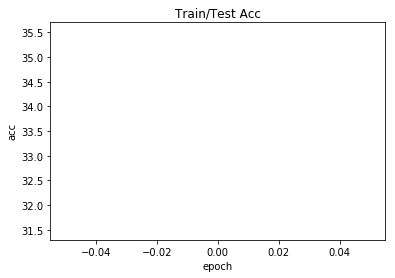

In [168]:
#plot train/val accuracies
print(train_acc)
plt.title("Train/Test Acc")
plt.xlabel("epoch")
plt.ylabel('acc')
plt.plot(train_acc, color='red')
plt.plot(val_acc, color='blue')
plt.show()